# In this notebook: test of the influence of a self-supervised auxiliary supervision term in a Domain Adaptation scenario

* Implementation of a semantic segmentation model augmented with a Temporal Consistency auxiliary supervision;
* Example of use of the library MMSegmentation;
* Modification of certain routines from the MMSegmentation lib;
* Development of new Dataset and Pipeline classes.

Set experiment attributes

In [ ]:
SEQ_DATASET = 'ZED2' # video dataset to be used for computing the auxiliary term
PRETRAINED = True # Cityscapes pretraining
MODEL_SPECS = 'bisenetv2_fcn_4x4_1024x1024_160k_cityscapes' # base model
MODEL_NAME = 'BiseNetv2'
BATCH_SIZE = 4
NUM_EPOCHS = 30 # number of adaptation epochs (considering a pretrained model)
TC_LOSS_WEIGHT=0.3 # weight given to the auxiliary term
CROP_SIZE = (300,300) # size of model inputs

Verify environment specs

In [ ]:
# verify the gpu type

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep  7 23:26:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%matplotlib inline

In [ ]:
# clear cell output
from IPython.display import clear_output

### Drive mounting

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Install MMSegmentation
This step may take several minutes.

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Install PyTorch
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0

clear_output()

In [ ]:
!rm -rf master-mmsegmentation
!git clone https://github.com/felipe-m-barbosa/master-mmsegmentation.git

%cd master-mmsegmentation/mmsegmentation-clone
!pip install -e .

clear_output()

In [ ]:
!pip install mmengine

clear_output()

In [ ]:
# !pip install torchmetrics
!pip install cityscapesscripts

clear_output()

In [ ]:
! pip install --quiet "pytorch-lightning>=1.4, <2.1.0" "torchvision" "setuptools==67.7.2" "lightning>=2.0.0rc0" "seaborn" "torchmetrics>=0.7, <0.12" "matplotlib>=3.0.0, <3.8.0" "torchmetrics >=0.11.0" "pandas" "torch>=1.8.1, <2.1.0" "ipython[notebook]>=8.0.0, <8.14.0" "urllib3"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openxlab 0.0.24 requires setuptools~=60.2.0, but you have setuptools 67.7.2 which is incompatible.


In [ ]:
import os

os.getcwd()

'/content/master-mmsegmentation/mmsegmentation-clone'

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")

# Check MMSegmentation installation
import mmseg
print(f"mmseg version: {mmseg.__version__}")

Torch version: 1.12.0+cu113
Cuda available: True
mmseg version: 0.29.1


In [ ]:
# mmsegmentation utilities
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

# python utilities
import matplotlib.pyplot as plt
import numpy as np
import cv2, mmcv
import os
import os.path as osp
import shutil
from tqdm import tqdm

## Functions and properties definition

In [ ]:
# Cityscapes classes
CLASSES = ('road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
               'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
               'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
               'bicycle')
COLOR2CLASS = {str(color):idx for idx, color in enumerate(get_palette('cityscapes'))}

## Organizing the dataset
1. Split the dataset into train and val sets
2. Define the dataset class
3. Build the dataset

In [ ]:
!pip install cityscapesscripts

clear_output()

In [ ]:
# Copyright (c) OpenMMLab. All rights reserved.
import os.path as osp
import warnings
from collections import OrderedDict

import mmcv
import numpy as np
from mmcv.utils import print_log
from prettytable import PrettyTable
from torch.utils.data import Dataset

from mmseg.core import eval_metrics, intersect_and_union, pre_eval_to_metrics
from mmseg.utils import get_root_logger

import warnings
from collections import OrderedDict

from mmcv.utils import print_log
from prettytable import PrettyTable
from torch.utils.data import Dataset

from mmseg.core import eval_metrics, intersect_and_union, pre_eval_to_metrics
from mmseg.utils import get_root_logger
from mmseg.datasets.pipelines import Compose, LoadAnnotations, newLoadAnnotations

from mmseg.datasets.builder import DATASETS
from mmseg.datasets.cityscapes import CityscapesDataset

In [ ]:
import os.path as osp

import mmcv
import numpy as np
from mmcv.utils import print_log
from PIL import Image

In [ ]:
import random

In [ ]:
# Reproducibility
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

mmseg.apis.set_random_seed(0, deterministic=True)

g = torch.Generator()
g.manual_seed(0)

In [ ]:
if osp.exists('/gdrive/MyDrive/'):
  my_drive = 'MyDrive'
else:
  my_drive = 'My Drive'

# scan and store filenames in a list
drive_data_root = f"/gdrive/{my_drive}/Mestrado/datasets/Cityscapes/512x1024/"
img_dir = 'leftImg8bit'
ann_dir = 'gtFine'

if SEQ_DATASET is not None:
  if SEQ_DATASET == 'Cityscapes':
    # Cityscapes SEQUENCES
    seq_dir = f"/gdrive/{my_drive}/Mestrado/datasets/Cityscapes/sequences/images"
    optflow_dir = f"/gdrive/{my_drive}/Mestrado/datasets/Cityscapes/sequences/opt_flows"
  elif SEQ_DATASET == 'SYNTHIA':
    # SYNTHIA SEQUENCES
    optflow_dir = f"/gdrive/{my_drive}/Mestrado/datasets/SYNTHIA/512x1024/opt_flow/"
    seq_dir = f"/gdrive/{my_drive}/Mestrado/datasets/SYNTHIA/512x1024/SEQ_TC/"
  else:
    #ZED2 SEQUENCES
    optflow_dir = f"/gdrive/{my_drive}/Mestrado/datasets/ZED2/512x1024/opt_flows/"
    seq_dir = f"/gdrive/{my_drive}/Mestrado/datasets/ZED2/512x1024/images/"


drive_imgs_root = osp.join(drive_data_root, img_dir)
drive_lbls_root = osp.join(drive_data_root, ann_dir)

In [ ]:
import cityscapesscripts.helpers.labels as CSLabels
import math

### Splitting the dataset

One of the ways MMSegmentation uses for defining train and validation sets is by reading txt files containing the filenames of images belonging to each of the sets. Hence, the user should define these txt files beforehand.

In [ ]:
split_dir = 'splits'

if SEQ_DATASET is not None:
  if not osp.exists(osp.join(drive_data_root, split_dir, SEQ_DATASET+'_train.txt')):
    # save train, test and val filenames in different txt files

    mmcv.mkdir_or_exist(osp.join(drive_data_root, split_dir))

    train_files = os.listdir(osp.join(drive_data_root, img_dir, 'train'))
    train_files = [f.replace('.png', '') for f in train_files]
    val_files = os.listdir(osp.join(drive_data_root, img_dir, 'val'))
    val_files = [f.replace('.png', '') for f in val_files]
    test_files = os.listdir(osp.join(drive_data_root, img_dir, 'test'))
    test_files = [f.replace('.png', '') for f in test_files]

    num_train_samples = len(train_files)
    num_test_samples = len(test_files)
    num_val_samples = len(val_files)

    if SEQ_DATASET == 'Cityscapes':
      with open(osp.join(drive_data_root, split_dir, SEQ_DATASET+'_train.txt'), 'w') as f:
        f.writelines(line + '\n' for line in train_files)

      with open(osp.join(drive_data_root, split_dir, SEQ_DATASET+'_val.txt'), 'w') as f:
        f.writelines(line + '\n' for line in val_files)

      with open(osp.join(drive_data_root, split_dir, SEQ_DATASET+'_test.txt'), 'w') as f:
        f.writelines(line + '\n' for line in test_files)

    elif SEQ_DATASET == 'ZED2':
      folders = os.listdir(seq_dir)

      print("folders: ", folders)

      for f in folders:
        print(f + ': ', len(os.listdir(osp.join(seq_dir, f))))

      num_files_folders = sum([len(os.listdir(osp.join(seq_dir, f))) for f in folders])
      # num_files_folder1 = len(os.listdir(osp.join(seq_dir, folders[0])))
      # num_files_folder2 = len(os.listdir(osp.join(seq_dir, folders[1])))
      # num_files_folder3 = len(os.listdir(osp.join(seq_dir, folders[2])))

      print("Soma1: ", (num_train_samples+num_val_samples+num_test_samples))
      print("Soma2: ", num_files_folders)

      if (num_train_samples+num_val_samples+num_test_samples) > num_files_folders:
        print("Sequences dataset does not match the number of samples in the labeled dataset")
        exit(1)

      num_folders = len(folders)
      pct_train = num_train_samples/5000
      pct_test = num_test_samples/5000
      pct_val = num_val_samples/5000



      train_indices_folders = {f:[] for f in folders}
      test_indices_folders = {f:[] for f in folders}
      val_indices_folders = {f:[] for f in folders}

      train_seq_names = []
      val_seq_names = []
      test_seq_names = []

      files_folders = {} # dict of folders and corresponding filenames (inside them)
      for folder in folders:
        files_folders[folder] = sorted(os.listdir(osp.join(seq_dir, folder)))


      for set_name, pct_samples in zip(['train', 'val', 'test'], [pct_train, pct_val, pct_test]):
        for folder, files in files_folders.items():
          list_indices = []
          list_names = []
          num_samples = math.floor(pct_samples*len(files))-1
          for i in tqdm(range(num_samples), desc=f"{set_name}-{folder}", total=num_samples):
            set_possible_choices = set(np.arange(len(files)-2))
            set_already_selected = set(list_indices+train_indices_folders[folder]+val_indices_folders[folder])

            choices_left = list(set_possible_choices.difference(set_already_selected))
            # print(len(choices_left))
            idx = random.sample(choices_left, 1)[0]

            list_names.append(osp.join(folder, files[idx]))

            list_indices.append(idx)

          if set_name == 'train':
            train_indices_folders[folder] = list_indices
            train_seq_names += list_names
          elif set_name == 'val':
            val_indices_folders[folder] = list_indices
            val_seq_names += list_names
          else:
            test_indices_folders[folder] = list_indices
            test_seq_names += list_names

      remaining_train_samples = num_train_samples - sum([len(train_indices_folders[f]) for f in folders])
      remaining_test_samples = num_test_samples - sum([len(test_indices_folders[f]) for f in folders])
      remaining_val_samples = num_val_samples - sum([len(val_indices_folders[f]) for f in folders])

      print("Processing remaining files")

      for set_name, num_samples in zip(['train', 'val', 'test'], [remaining_train_samples, remaining_val_samples, remaining_test_samples]):
        for _ in range(num_samples):
          # sort a folder
          folder_idx = random.randint(0,2)
          folder = folders[folder_idx]
          # indices already chosen
          already_chosen = set(train_indices_folders[folder]+val_indices_folders[folder]+test_indices_folders[folder])
          all_possible = set(np.arange(len(files_folders[folder])-2))
          available = list(all_possible.difference(already_chosen))

          if not(len(available) > 0):
            continue

          # randomly choose a file index from the available ones
          idx = random.sample(available, 1)[0]

          # given that the index is valid, store the idx and the filename corresponding to it
          if set_name == 'train':
            train_indices_folders[folder] += idx
            train_seq_names += osp.join(folder, files_folders[folder][idx])
          elif set_name == 'val':
            val_indices_folders[folder] += idx
            val_seq_names += osp.join(folder, files_folders[folder][idx])
          else:
            test_indices_folders[folder] += idx
            test_seq_names += osp.join(folder, files_folders[folder][idx])

      random.shuffle(train_seq_names)
      random.shuffle(val_seq_names)
      random.shuffle(test_seq_names)


      with open(osp.join(drive_data_root, split_dir, SEQ_DATASET+'_train.txt'), 'w') as f:
        f.writelines(tf+'**'+ts + '\n' for tf, ts in zip(train_files, train_seq_names))

      with open(osp.join(drive_data_root, split_dir, SEQ_DATASET+'_val.txt'), 'w') as f:
        f.writelines(tf+'**'+ts + '\n' for tf, ts in zip(val_files, val_seq_names))

      with open(osp.join(drive_data_root, split_dir, SEQ_DATASET+'_test.txt'), 'w') as f:
        f.writelines(tf+'**'+ts + '\n' for tf, ts in zip(test_files, test_seq_names))

### Test pretrained model

In [ ]:
# download pre-trained weights
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/bisenetv2/bisenetv2_fcn_4x4_1024x1024_160k_cityscapes/bisenetv2_fcn_4x4_1024x1024_160k_cityscapes_20210902_015551-bcf10f09.pth -P checkpoints
# !wget https://download.openmmlab.com/mmsegmentation/v0.5/bisenetv1/bisenetv1_r18-d32_in1k-pre_4x4_1024x1024_160k_cityscapes/bisenetv1_r18-d32_in1k-pre_4x4_1024x1024_160k_cityscapes_20210905_220251-8ba80eff.pth -P checkpoints

--2023-09-07 23:26:59--  https://download.openmmlab.com/mmsegmentation/v0.5/bisenetv2/bisenetv2_fcn_4x4_1024x1024_160k_cityscapes/bisenetv2_fcn_4x4_1024x1024_160k_cityscapes_20210902_015551-bcf10f09.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.48.85.213, 8.48.85.207, 8.48.85.211, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.48.85.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59450232 (57M) [application/octet-stream]
Saving to: ‘checkpoints/bisenetv2_fcn_4x4_1024x1024_160k_cityscapes_20210902_015551-bcf10f09.pth’

bisenetv2_fcn_4x4_1 100%[===================>]  56.70M  7.63MB/s    in 8.3s    

2023-09-07 23:27:08 (6.83 MB/s) - ‘checkpoints/bisenetv2_fcn_4x4_1024x1024_160k_cityscapes_20210902_015551-bcf10f09.pth’ saved [59450232/59450232]



In [ ]:
def dummy_eval(model, img_path):
  model.eval()

  sample_path = osp.join(drive_imgs_root, 'test', img_path)
  img = mmcv.imread(sample_path)

  result = inference_segmentor(model, img)
  plt.figure(figsize=(8, 6))
  show_result_pyplot(model, img, result, get_palette('cityscapes'))

  model.train()

In [ ]:
# defining paths for config file and pre-trained weights
# config_file = 'configs/bisenetv1/bisenetv1_r18-d32_in1k-pre_4x4_1024x1024_160k_cityscapes.py'
# checkpoint_file = 'checkpoints/bisenetv1_r18-d32_in1k-pre_4x4_1024x1024_160k_cityscapes_20210905_220251-8ba80eff.pth'

config_file = 'configs/bisenetv2/bisenetv2_fcn_4x4_1024x1024_160k_cityscapes.py'
checkpoint_file = 'checkpoints/bisenetv2_fcn_4x4_1024x1024_160k_cityscapes_20210902_015551-bcf10f09.pth'

In [ ]:
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

/content/master-mmsegmentation/mmsegmentation-clone/mmseg/models/losses/cross_entropy_loss.py:247: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: checkpoints/bisenetv2_fcn_4x4_1024x1024_160k_cityscapes_20210902_015551-bcf10f09.pth


berlin_000479_000019_leftImg8bit.png


/content/master-mmsegmentation/mmsegmentation-clone/mmseg/models/segmentors/base.py:299: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 800x600 with 0 Axes>

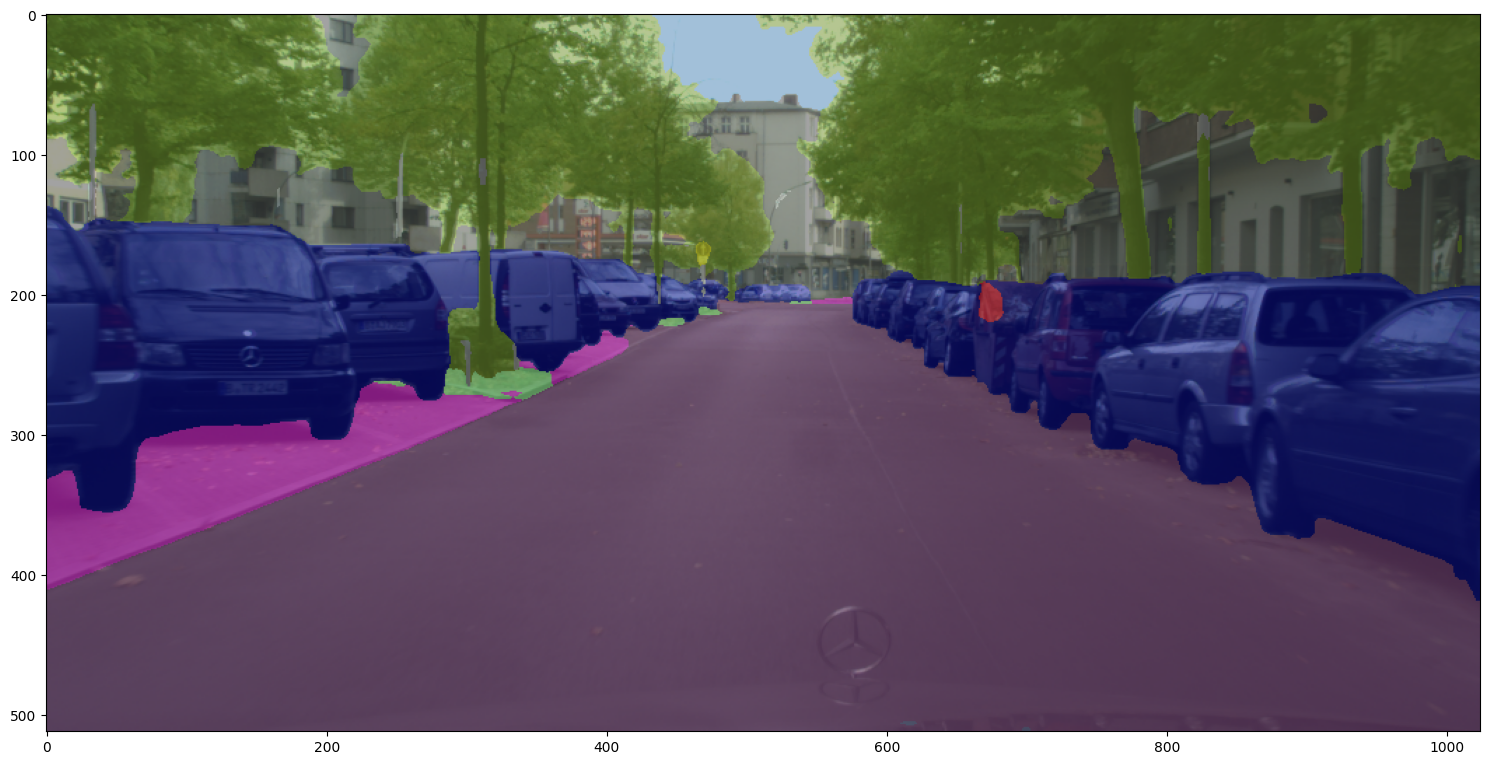

In [ ]:
test_imgs = os.listdir(osp.join(drive_imgs_root, 'test'))
print(test_imgs[0])

dummy_eval(model, test_imgs[0])

In [ ]:
from mmcv import Config
cfg = Config.fromfile(config_file)

# print(cfg.pretty_text)

In [ ]:
# Let's have a look at the config
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='BiSeNetV2',
        detail_channels=(64, 64, 128),
        semantic_channels=(16, 32, 64, 128),
        semantic_expansion_ratio=6,
        bga_channels=128,
        out_indices=(0, 1, 2, 3, 4),
        init_cfg=None,
        align_corners=False),
    decode_head=dict(
        type='FCNHead',
        in_channels=128,
        in_index=0,
        channels=1024,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=[
        dict(
            type='FCNHead',
            in_channels=16,
            channels=16,
            num_convs=2,
            num_classes=19,
            in_index=1,
   

---

### Modify the config file

We need to modify the config for the training:
* Include our auxiliary loss in the main decode head
* Include our modified pipelines so that to process the auxiliary sequential input (pipeline classes with the prefix 'new')

#### New Config

In [ ]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head[0].norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head[1].norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head[2].norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head[3].norm_cfg = cfg.norm_cfg

cfg.model.decode_head.ignore_index = 255
cfg.model.auxiliary_head[0].ignore_index = 255
cfg.model.auxiliary_head[1].ignore_index = 255
cfg.model.auxiliary_head[2].ignore_index = 255
cfg.model.auxiliary_head[3].ignore_index = 255

if SEQ_DATASET is not None:
  cfg.model.decode_head.loss_decode = [
      dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=(1.0-TC_LOSS_WEIGHT), avg_non_ignore=True),
      dict(type='TCLoss', loss_weight=TC_LOSS_WEIGHT, loss_name='loss_tc', avg_non_ignore=True)]
else:
  cfg.model.decode_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True)

# cfg.model.decode_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True)
cfg.model.auxiliary_head[0].loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True)
cfg.model.auxiliary_head[1].loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True)
cfg.model.auxiliary_head[2].loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True)
cfg.model.auxiliary_head[3].loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True)

# Modify dataset type and path
cfg.dataset_type = 'newCityscapesDataset1' if SEQ_DATASET is not None else 'CityscapesDataset'
cfg.data_root = drive_data_root

cfg.data.samples_per_gpu = BATCH_SIZE
cfg.data.workers_per_gpu= 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = CROP_SIZE

if SEQ_DATASET is not None:
  cfg.train_pipeline = [
      dict(type='newLoadImageFromFile'),
      dict(type='newLoadAnnotations'),
      dict(type='newResize', img_scale=(int(2*CROP_SIZE[0]), CROP_SIZE[1]), ratio_range=(0.5, 2.0)),
      dict(type='newRandomCrop', crop_size=cfg.crop_size), #  cat_max_ratio=0.75
      dict(type='RandomFlip', flip_ratio=0.5),
      dict(type='PhotoMetricDistortion'),
      dict(type='newNormalize', **cfg.img_norm_cfg),
      dict(type='newPad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
      dict(type='newDefaultFormatBundle'),
      dict(type='Collect', keys=['img', 'gt_semantic_seg', 's1_img', 's2_img', 'opt_flow']),
  ]

  cfg.test_pipeline = [
      dict(type='newLoadImageFromFile'),
      dict(
          type='MultiScaleFlipAug',
          img_scale=(int(2*CROP_SIZE[0]), CROP_SIZE[1]),
          # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
          flip=False,
          transforms=[
              dict(type='Resize', keep_ratio=True),
              dict(type='RandomFlip'),
              dict(type='Normalize', **cfg.img_norm_cfg),
              dict(type='ImageToTensor', keys=['img']),
              dict(type='Collect', keys=['img']),
          ])
  ]


  cfg.data.train.type = cfg.dataset_type
  cfg.data.train.data_root = cfg.data_root
  cfg.data.train.img_dir = osp.join(img_dir, 'train')
  cfg.data.train.ann_dir = osp.join(ann_dir, 'train')
  # cfg.data.train.seg_map_suffix = '_gtFine_labelIds.png'
  cfg.data.train.seq_dir = seq_dir if SEQ_DATASET == 'ZED2' else osp.join(seq_dir, 'train')
  cfg.data.train.optflow_dir = optflow_dir if SEQ_DATASET == 'ZED2' else osp.join(optflow_dir, 'train')
  cfg.data.train.pipeline = cfg.train_pipeline
  cfg.data.train.split = f'splits/{SEQ_DATASET}_train.txt'

  cfg.data.val.type = cfg.dataset_type
  cfg.data.val.data_root = cfg.data_root
  cfg.data.val.img_dir = osp.join(img_dir, 'val')
  cfg.data.val.ann_dir = osp.join(ann_dir, 'val')
  # cfg.data.val.seg_map_suffix = '_gtFine_labelIds.png'
  cfg.data.val.seq_dir = seq_dir if SEQ_DATASET == 'ZED2' else osp.join(seq_dir, 'val')
  cfg.data.val.optflow_dir = optflow_dir if SEQ_DATASET == 'ZED2' else osp.join(optflow_dir, 'val')
  cfg.data.val.pipeline = cfg.test_pipeline
  cfg.data.val.split = f'splits/{SEQ_DATASET}_val.txt'

  cfg.data.test.type = cfg.dataset_type
  cfg.data.test.data_root = cfg.data_root
  cfg.data.test.img_dir = osp.join(img_dir, 'test')
  cfg.data.test.ann_dir = osp.join(ann_dir, 'test')
  # cfg.data.test.seg_map_suffix = '_gtFine_labelIds.png'
  cfg.data.test.seq_dir = seq_dir if SEQ_DATASET == 'ZED2' else osp.join(seq_dir, 'test')
  cfg.data.test.optflow_dir = optflow_dir if SEQ_DATASET == 'ZED2' else osp.join(optflow_dir, 'test')
  cfg.data.test.pipeline = cfg.test_pipeline
  cfg.data.test.split = f'splits/{SEQ_DATASET}_test.txt'

else:
  cfg.train_pipeline = [
      dict(type='LoadImageFromFile'),
      dict(type='LoadAnnotations'),
      dict(type='Resize', img_scale=(int(2*CROP_SIZE[0]), CROP_SIZE[1]), ratio_range=(0.5, 2.0)),
      dict(type='RandomCrop', crop_size=cfg.crop_size), #  cat_max_ratio=0.75
      dict(type='RandomFlip', flip_ratio=0.5),
      dict(type='PhotoMetricDistortion'),
      dict(type='Normalize', **cfg.img_norm_cfg),
      dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
      dict(type='DefaultFormatBundle'),
      dict(type='Collect', keys=['img', 'gt_semantic_seg']),
  ]

  cfg.test_pipeline = [
      dict(type='LoadImageFromFile'),
      dict(
          type='MultiScaleFlipAug',
          img_scale=(int(2*CROP_SIZE[0]), CROP_SIZE[1]),
          # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
          flip=False,
          transforms=[
              dict(type='Resize', keep_ratio=True),
              dict(type='RandomFlip'),
              dict(type='Normalize', **cfg.img_norm_cfg),
              dict(type='ImageToTensor', keys=['img']),
              dict(type='Collect', keys=['img']),
          ])
  ]


  cfg.data.train.type = cfg.dataset_type
  cfg.data.train.data_root = cfg.data_root
  cfg.data.train.img_dir = osp.join(img_dir, 'train')
  cfg.data.train.ann_dir = osp.join(ann_dir, 'train')
  cfg.data.train.seg_map_suffix = '_gtFine_labelIds.png'
  cfg.data.train.pipeline = cfg.train_pipeline
  # cfg.data.train.split = 'splits/train.txt'

  cfg.data.val.type = cfg.dataset_type
  cfg.data.val.data_root = cfg.data_root
  cfg.data.val.img_dir = osp.join(img_dir, 'val')
  cfg.data.val.ann_dir = osp.join(ann_dir, 'val')
  cfg.data.test.seg_map_suffix = '_gtFine_labelIds.png'
  cfg.data.val.pipeline = cfg.test_pipeline
  # cfg.data.val.split = 'splits/val.txt'

  cfg.data.test.type = cfg.dataset_type
  cfg.data.test.data_root = cfg.data_root
  cfg.data.test.img_dir = osp.join(img_dir, 'test')
  cfg.data.test.ann_dir = osp.join(ann_dir, 'test')
  cfg.data.val.seg_map_suffix = '_gtFine_labelIds.png'
  cfg.data.test.pipeline = cfg.test_pipeline
  # cfg.data.test.split = 'splits/test.txt'

# Load pre-trained weights
# cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = f"/gdrive/{my_drive}/Mestrado/Qualificacao/TestesPreliminares/Pytorch/NORM_TC_LOSS_mIOU_{MODEL_NAME}_ep-{NUM_EPOCHS}_bs-{BATCH_SIZE}_pt-{PRETRAINED}_seq_ds-{SEQ_DATASET}_tc_lw-{TC_LOSS_WEIGHT}_cs-{CROP_SIZE[0]}x{CROP_SIZE[1]}"

if osp.exists(cfg.work_dir+'/latest.pth'):
  cfg.resume_from = cfg.work_dir+'/latest.pth'
# elif PRETRAINED:
#   cfg.load_from = 'checkpoints/bisenetv2_fcn_4x4_1024x1024_160k_cityscapes_20210902_015551-bcf10f09.pth'
else: # is this necessary?
  cfg.load_from = None

# cfg.runner.max_iters = 200
# cfg.log_config.interval = 10
# cfg.evaluation.interval = 10
# cfg.checkpoint_config.interval = 5

# cfg.log_config.interval = 371
cfg.log_config.interval = 100
# cfg.log_config.hooks[0].by_epoch = True
cfg.log_config.hooks = [dict(type='TextLoggerHook', by_epoch=False), dict(type='TensorboardLoggerHook', by_epoch=False)]

# cfg.lr_config.by_epoch = True

# cfg.checkpoint_config = dict(by_epoch=True, interval=5, save_optimizer=True)

# cfg.runner = dict(type='EpochBasedRunner', max_epochs=NUM_EPOCHS)

# optimizer
cfg.optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict()
# learning policy
cfg.lr_config = dict(policy='poly', power=0.9, min_lr=1e-4, by_epoch=False)
# runtime settings
# cfg.runner = dict(type='IterBasedRunner', max_iters=NUM_ITERS)
# cfg.checkpoint_config = dict(by_epoch=False, interval=NUM_ITERS/100, save_optimizer=True)
# cfg.evaluation = dict(interval=NUM_ITERS/100, metric=['mIoU'])


# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=True) # not sure if True or False ...
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='BiSeNetV2',
        detail_channels=(64, 64, 128),
        semantic_channels=(16, 32, 64, 128),
        semantic_expansion_ratio=6,
        bga_channels=128,
        out_indices=(0, 1, 2, 3, 4),
        init_cfg=None,
        align_corners=False,
        norm_cfg=dict(type='BN', requires_grad=True)),
    decode_head=dict(
        type='FCNHead',
        in_channels=128,
        in_index=0,
        channels=1024,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(
                type='CrossEntropyLoss',
                use_sigmoid=False,
                loss_weight=0.7,
                avg_non_ignore=True),
            dict(
                type='TCLoss',
               

In [ ]:
my_drive

'MyDrive'

In [ ]:
from mmseg.datasets import build_dataset

# Build the training dataset using the data training configs previously defined in the configs file
datasets = [build_dataset(cfg.data.train)]

2023-09-07 23:30:13,468 - mmseg - INFO - Loaded 1876 images
2023-09-07 23:33:08,190 - mmseg - INFO - Loaded 1876 images


In [ ]:
print(f"Number of samples: {datasets[0].__len__()}")

Number of samples: 1876


In [ ]:
# for i in range(datasets[0].__len__()):
#   print(datasets[0].img_infos[i]['filename'])

In [ ]:
num_samples = datasets[0].__len__()
num_batches_epoch = num_samples//BATCH_SIZE + int(num_samples%BATCH_SIZE != 0)
NUM_ITERS = NUM_EPOCHS*num_batches_epoch

cfg.runner = dict(type='IterBasedRunner', max_iters=NUM_ITERS)

In [ ]:
cfg.checkpoint_config = dict(by_epoch=False, interval=num_batches_epoch, save_optimizer=True) # every one epoch
cfg.evaluation = dict(interval=3*num_batches_epoch, metric=['mIoU']) # every three epochs

In [ ]:
cfg.log_config.interval = datasets[0].__len__()//BATCH_SIZE # every one epoch

In [ ]:
datasets[0].img_infos[:2]

[{'filename': 'tubingen_000002_000019_leftImg8bit.png',
  'ann': {'seg_map': 'tubingen_000002_000019_gtFine_labelIds.png'},
  's1': {'filename': '/gdrive/MyDrive/Mestrado/datasets/ZED2/512x1024/images/morning_overcast_05/bauru_morning_overcast_05_507_leftImg8bit.png'},
  'from_target': True,
  's2': {'filename': '/gdrive/MyDrive/Mestrado/datasets/ZED2/512x1024/images/morning_overcast_05/bauru_morning_overcast_05_508_leftImg8bit.png'},
  'optflow': {'filename': '/gdrive/MyDrive/Mestrado/datasets/ZED2/512x1024/opt_flows/morning_overcast_05/bauru_morning_overcast_05_507_opt_flow.flo'}},
 {'filename': 'tubingen_000003_000019_leftImg8bit.png',
  'ann': {'seg_map': 'tubingen_000003_000019_gtFine_labelIds.png'},
  's1': {'filename': '/gdrive/MyDrive/Mestrado/datasets/ZED2/512x1024/images/morning_overcast_04/bauru_morning_overcast_04_2201_leftImg8bit.png'},
  'from_target': True,
  's2': {'filename': '/gdrive/MyDrive/Mestrado/datasets/ZED2/512x1024/images/morning_overcast_04/bauru_morning_over

In [ ]:
# for idx in range(50):
#   print(datasets[0].__getitem__(idx)['img'].data.shape)

## Training/fine-tuning
  * Download pre-trained weights
  * Build model according to the config file

## Train/Fine-tuning and Evaluation

In [ ]:
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

In [ ]:
import cityscapesscripts.helpers.labels as CSLabels

eval_palette = np.zeros((len(CSLabels.trainId2label), 3), dtype=np.uint8)
for label_id, label in CSLabels.trainId2label.items():
    if label_id != 255:
        eval_palette[label_id] = label.color

In [ ]:
# Build the segmentor, from the config file
model = build_segmentor(cfg.model)

## Eval functions (for setting the baseline)

In [ ]:
from torchmetrics import JaccardIndex

def tc_eval(model):

  model.eval()

  # dst_dir = 'eval_imgs'
  # mmcv.mkdir_or_exist(dst_dir)

  eval_criterion = JaccardIndex(task='multiclass', num_classes=19, ignore_index=255)
  eval_per_class_criterion = JaccardIndex(task='multiclass', num_classes=19, ignore_index=255, average='none')


  eval_data_root = '/gdrive/MyDrive/Mestrado/datasets/Cityscapes/demoVideo/stuttgart_00'
  eval_img_root = osp.join(eval_data_root, 'leftImg8bit')
  eval_optflow_root = osp.join(eval_data_root, 'opt_flow')

  filenames = os.listdir(eval_img_root)
  filenames = sorted(filenames, key=lambda x: int(x.split('_')[-2]))
  filenames = [osp.join(eval_img_root, f) for f in filenames]

  miou_acc = 0
  per_class_miou_acc = torch.zeros(19)

  imgs_count = 0
  max_imgs = 100

  for f1, f2 in tqdm(zip(filenames[:-1], filenames[1:]), total=max_imgs):
      imgs_count += 1

      if imgs_count > max_imgs:
        break

      img1 = mmcv.imread(f1)
      img2 = mmcv.imread(f2)

      optflow = mmcv.flowread(osp.join(eval_optflow_root, f1.split(osp.sep)[-1].replace('leftImg8bit.png', 'opt_flow.flo')))

      with torch.no_grad():
          result1 = inference_segmentor(model, img1)[0]
          result2 = inference_segmentor(model, img2)[0]

          result1 = torch.as_tensor(result1).unsqueeze(2).type(torch.float32)
          result1 = result1.detach().cpu().numpy()

          # print('\n\n\n')
          # print(result1.shape)
          # print('\n\n\n')

          result1_warped = mmcv.flow_warp(result1, optflow)

          result1_warped = result1_warped.squeeze()

          # # save imgs
          # result1 = result1.squeeze()
          # color_pred = Image.fromarray(result1.astype(np.uint8)).convert('P')
          # color_pred.putpalette(eval_palette)
          # color_pred.save(osp.join(dst_dir, f1.split(osp.sep)[-1]))

          # calculate metrics
          miou = eval_criterion(torch.as_tensor(result1_warped), torch.as_tensor(result2))
          per_class_miou = eval_per_class_criterion(torch.as_tensor(result1_warped), torch.as_tensor(result2))

          miou_acc += miou
          per_class_miou_acc += per_class_miou

          # # save imgs
          # result1 = result1.squeeze()
          # color_pred = Image.fromarray(result1.astype(np.uint8)).convert('P')
          # color_pred.putpalette(eval_palette)
          # color_pred.save(osp.join(dst_dir, f1.split(osp.sep)[-1]))

  total_miou = miou_acc/max_imgs
  total_per_class_miou = per_class_miou_acc/max_imgs

  # print("total_miou: ", total_miou)
  # print("per-class miou: ", total_per_class_miou)

  model.train()

  return total_miou, total_per_class_miou

In [ ]:
from torchmetrics import JaccardIndex

def first_eval(model, img_set):
  model.eval()

  criterion = JaccardIndex(task='multiclass', num_classes=19, ignore_index=255)
  per_class_criterion = JaccardIndex(task='multiclass', num_classes=19, ignore_index=255, average='none')

  seg_dst_dir = osp.join('eval_imgs', 'seg_maps')
  mmcv.mkdir_or_exist(seg_dst_dir)

  imgs = os.listdir(osp.join(drive_imgs_root, img_set))
  imgs = sorted(imgs)
  lbls = os.listdir(osp.join(drive_lbls_root, img_set))
  lbls = sorted(lbls)

  miou_acc = 0
  per_class_miou_acc = torch.zeros(19)

  for i, l in tqdm(zip(imgs, lbls), total=len(imgs)):

    label = mmcv.imread(osp.join(drive_lbls_root, img_set, l))
    lbl_ids = label[:,:,0]

    # convert labelid to train id
    train_ids = np.zeros_like(lbl_ids)
    for lbl_id, label in CSLabels.id2label.items():
      train_ids[lbl_ids==lbl_id] = label.trainId

    label = train_ids

    # inference
    with torch.no_grad():
      result = inference_segmentor(model, osp.join(drive_imgs_root, img_set, i))

      seg_map = result[0]

      miou = criterion(torch.as_tensor(seg_map), torch.as_tensor(label))
      per_class_miou = per_class_criterion(torch.as_tensor(seg_map), torch.as_tensor(label))

      miou_acc += miou
      per_class_miou_acc += per_class_miou

  total_miou = miou_acc/len(imgs)
  total_per_class_miou = per_class_miou_acc/len(imgs)

  model.train()

  return total_miou, total_per_class_miou

In [ ]:
# test_imgs = os.listdir(osp.join(drive_imgs_root, 'test'))
# dummy_eval(model, test_imgs[0])

In [ ]:
# pytorch_total_params = sum(p.numel() for p in model.parameters())
# pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print('pytorch_total_params: ', pytorch_total_params)
# print('pytorch_trainable_params: ', pytorch_trainable_params)

In [ ]:
# tc, per_class_tc = tc_eval(model)
# print(f"TC: {tc}")
# print(f"Class-wise TC: {per_class_tc}")
# print("\n\n")
# train_miou, train_per_class_miou = first_eval(model, img_set='train')
# print(f"Train mIoU: {train_miou}")
# print(f"Class-wise Train mIoU: {train_per_class_miou}")
# print("\n\n")
# val_miou, val_per_class_miou = first_eval(model, img_set='val')
# print(f"Val mIoU: {val_miou}")
# print(f"Class-wise Val mIoU: {val_per_class_miou}")

## Fine-tuning

In [ ]:
from mmcv.runner import load_checkpoint

# recover latest weights
if PRETRAINED and not(osp.exists(cfg.work_dir+'/latest.pth')):
  checkpoint = load_checkpoint(model, checkpoint_file, map_location='cuda:0')
  model.CLASSES = checkpoint['meta']['CLASSES']
  model.cfg = cfg

In [ ]:
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES # CHECK

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2023-09-07 23:33:59,698 - mmseg - INFO - Loaded 499 images
2023-09-07 23:34:46,912 - mmseg - INFO - Loaded 499 images
2023-09-07 23:34:46,915 - mmseg - INFO - load checkpoint from local path: /gdrive/MyDrive/Mestrado/Qualificacao/TestesPreliminares/Pytorch/NORM_TC_LOSS_mIOU_BiseNetv2_ep-30_bs-4_pt-True_seq_ds-ZED2_tc_lw-0.3_cs-300x300/latest.pth
2023-09-07 23:34:47,209 - mmseg - INFO - resumed from epoch: 7, iter 2819
2023-09-07 23:34:47,211 - mmseg - INFO - Start running, host: root@79d2faa8cfdf, work_dir: /gdrive/MyDrive/Mestrado/Qualificacao/TestesPreliminares/Pytorch/NORM_TC_LOSS_mIOU_BiseNetv2_ep-30_bs-4_pt-True_seq_ds-ZED2_tc_lw-0.3_cs-300x300
2023-09-07 23:34:47,212 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook  

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 499/499, 31.0 task/s, elapsed: 16s, ETA:     0s

2023-09-07 23:43:14,062 - mmseg - INFO - per class results:
2023-09-07 23:43:14,066 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|      road     | 94.15 | 96.44 |
|    sidewalk   | 59.86 | 75.74 |
|    building   | 75.75 | 87.47 |
|      wall     | 11.69 | 12.15 |
|     fence     |  6.21 |  7.0  |
|      pole     | 20.62 | 30.74 |
| traffic light |  8.3  | 10.95 |
|  traffic sign | 16.09 | 17.74 |
|   vegetation  | 78.04 | 93.77 |
|    terrain    | 28.34 | 31.01 |
|      sky      | 81.45 | 86.97 |
|     person    | 38.15 |  62.5 |
|     rider     |  4.78 |  5.11 |
|      car      | 78.57 | 88.89 |
|     truck     |  7.18 |  7.61 |
|      bus      |  28.4 | 43.35 |
|     train     | 19.37 | 34.01 |
|   motorcycle  |  5.46 |  6.53 |
|    bicycle    | 33.87 | 68.53 |
+---------------+-------+-------+
2023-09-07 23:43:14,067 - mmseg - INFO - Summary:
2023-09-07 23:43:14,068 - mmseg - INFO - 
+------+-------+-------+

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 499/499, 31.2 task/s, elapsed: 16s, ETA:     0s

2023-09-07 23:51:43,144 - mmseg - INFO - per class results:
2023-09-07 23:51:43,146 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|      road     | 94.06 | 97.03 |
|    sidewalk   | 59.36 |  72.6 |
|    building   | 78.64 | 89.02 |
|      wall     | 15.85 | 16.62 |
|     fence     | 16.52 | 23.08 |
|      pole     |  19.7 | 26.27 |
| traffic light |  7.75 |  8.7  |
|  traffic sign | 17.14 | 18.32 |
|   vegetation  | 79.27 | 93.81 |
|    terrain    | 30.21 | 32.89 |
|      sky      | 83.48 | 88.47 |
|     person    | 39.75 | 70.72 |
|     rider     | 14.74 | 19.22 |
|      car      | 79.15 | 89.17 |
|     truck     | 26.01 | 33.95 |
|      bus      |  6.39 |  6.96 |
|     train     | 12.85 | 67.08 |
|   motorcycle  |  8.0  |  9.91 |
|    bicycle    | 39.09 | 60.52 |
+---------------+-------+-------+
2023-09-07 23:51:43,147 - mmseg - INFO - Summary:
2023-09-07 23:51:43,148 - mmseg - INFO - 
+-------+-------+-------

KeyboardInterrupt: ignored

In [ ]:
# Stop and remove runtime, so that we don't waste computation time while idle
from google.colab import runtime

runtime.unassign()

## Auxiliary functions for:
* compressing a folder
* downloading a folder

In [ ]:
# !zip -r eval_imgs.zip eval_imgs/

# clear_output()

In [ ]:
# from google.colab import files
# files.download("eval_imgs.zip")